In [468]:
# Learn distribution of psi and x for AR1 using the ensemble information filter
import functools
import graphspme
import numpy as np
from scipy import sparse
import math
import matplotlib.pyplot as plt
from sksparse.cholmod import cholesky
from scipy.sparse.linalg import inv as sparse_inv
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams.update({'font.size': 18})

In [469]:
# Set up transformations
def rar1_epoch(psi, x0):
    """Simulates an AR1 timestep"""
    return psi * x0 + np.random.normal(0,1,1)

# zero mean AR1
def rar1(n, psi):
    """Simulate a full AR1 process"""
    x = np.empty([n])
    x[0] = np.random.normal(0, 1 / math.sqrt(1 - psi**2), 1)
    for i in range(1, n):
        x[i] = rar1_epoch(psi, x[i-1])
    return x

def m(x, theta):
    """Forward model used in predict-step"""
    psi = theta
    return rar1_epoch(psi, x)

In [470]:
# Set up problem
n = 100 # ensemble size
T = 50 # timesteps
H = np.array([[1]]) # a direct measurement at some time
mu = np.array([10.0])
Prec = np.array([[0.01]])
Prec_y = np.array([[1]])
G = sparse.diags([[1]*1], [0], format="csr")

In [471]:
def sample_chol(z, mu, Prec):
    """Computationally efficient random sample from N(mu,Prec)"""
    Prec = sparse.csc_matrix(Prec) # ensure sparsity type
    L = cholesky(Prec).L()
    return mu + sparse_inv(L) @ z

In [472]:
def estimate_parameters(x_ens, G):
    """Estimate mean-precision parametrisation w.r.t. graph G"""
    mu_est = x_ens.mean(axis=0)
    Prec_est = graphspme.prec_sparse(x_ens, G, True)
    return mu_est, Prec_est

def update_parameters(yi, H, mu, Prec, Prec_y):
    """Information filter data assimilation"""
    yi = np.array([yi])
    eta = Prec @ mu
    eta = eta + H.T @ Prec_y @ yi
    Prec = Prec + H.T @ Prec_y @ H
    Prec = sparse.csr_matrix(Prec)
    return eta, Prec

def retrieve_mean(eta, Prec):
    """Computationally efficient transform to mean from eta"""
    return sparse_inv(Prec) @ eta #naive solution - not efficient

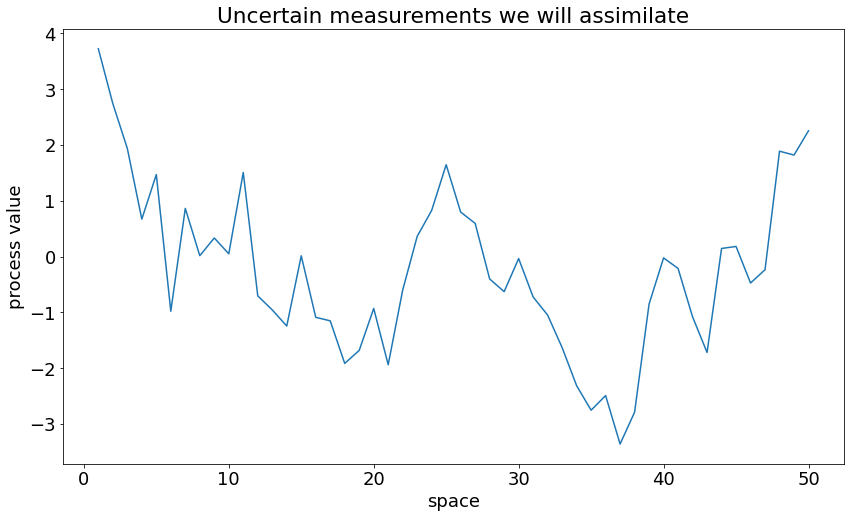

In [473]:
# Create observations
np.random.seed(1)
psi = 0.9
time = np.linspace(1,T,T)
y = rar1(T, psi)
plot1 = plt.figure(1)
plt.plot(time, y)
plt.title("Uncertain measurements we will assimilate")
plt.ylabel("process value")
plt.xlabel("space")
plt.show()

In [474]:
# Sample 
z = np.random.normal(0,1,n)

In [475]:
track_mean_prior = []
track_mean_posterior = []

for t in range(T):
    track_mean_prior.append(mu[0])
    
    # Sample realisations
    x_ens = np.array([sample_chol(z[i:(i+1)], mu, Prec) for i in range(T)])
    # Predict ensemble
    x_ens = np.array([m(xi, psi) for xi in x_ens])
    # Estimate eta-precision parameters
    mu, Prec = estimate_parameters(x_ens, G)
    # Assimilate data, updating canonical parametrisation
    eta, Prec = update_parameters(y[t:(t+1)], H, mu, Prec, Prec_y)
    # Retrieve mean-precision parametrisation
    mu = retrieve_mean(eta, Prec)
    
    track_mean_posterior.append(mu[0])

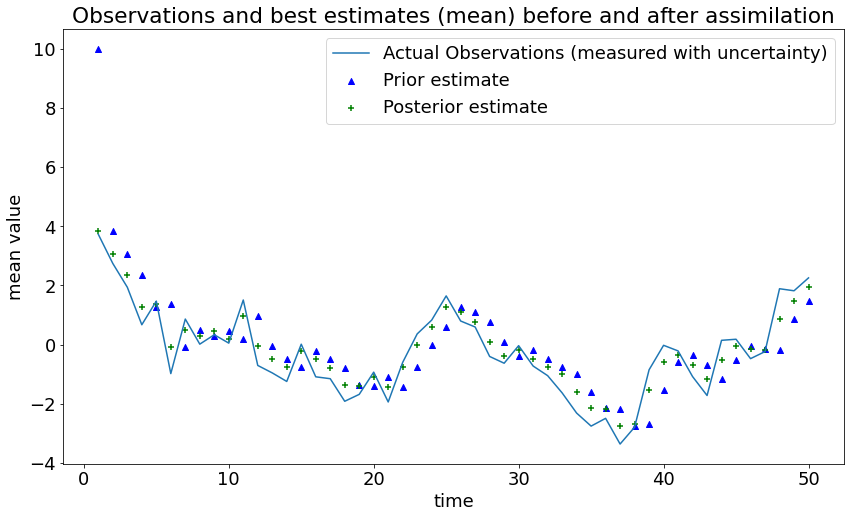

In [476]:
plot2 = plt.figure(2)
plt.plot(time, y)
plt.scatter(time, track_mean_prior, color="blue", marker="^")
plt.scatter(time, track_mean_posterior, color="green", marker="+")
plt.legend([
    'Actual Observations (measured with uncertainty)', 
    'Prior estimate',
    'Posterior estimate'])
plt.title("Observations and best estimates (mean) before and after assimilation")
plt.ylabel("mean value")
plt.xlabel("time")
plt.show()